In [9]:
# ! pip install torch==2.4.1 torchvision==0.19.0
# ! pip install accelerate==0.34.2
# ! pip install transformers==4.45.1
# ! pip install unsloth==2024.9.post3
# ! pip install bitsandbytes==0.44.0
# ! pip install qwen-vl-utils
# ! pip install optimum
# ! pip install auto-gptq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.6/422.6 kB 5.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 9.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 9.2 MB/s eta 0:00:0000:0100:01


In [1]:
%env CUDA_VISIBLE_DEVICES=0,1
%env TOKENIZERS_PARALLELISM=false

env: CUDA_VISIBLE_DEVICES=0,1
env: TOKENIZERS_PARALLELISM=false


In [2]:
# BASE_PATH = "/kaggle/input"
BASE_PATH = "/home/stepan/kaggle-arc-agi"
# MODEL_ID = f"unsloth/Meta-Llama-3.1-8B-bnb-4bit"
MODEL_ID = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
# VLLM_MODEL_ID = "unsloth/Llama-3.2-11B-Vision-Instruct"
VLLM_MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct-GPTQ-Int4"
# VLLM_MODEL_ID = "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4"
MAX_NEW_TOKENS = 2048
MAX_SEQ_LENGTH = 32768 - MAX_NEW_TOKENS

In [3]:
# LLM_HIDDEN_SIZE = 4096 # 8B
# VLLM_HIDDEN_SIZE = 3584 #7B
LLM_HIDDEN_SIZE = 3072  # 3B
VLLM_HIDDEN_SIZE = 1536  # 2B

In [4]:
import sys

sys.path.append(BASE_PATH)
sys.path.append(f"{BASE_PATH}/scripts")
# sys.path.append('/kaggle/input/arc-agi-python-utilities')

In [5]:
! pip show unsloth

Name: unsloth
Version: 2025.2.4
Summary: 2-5X faster LLM finetuning
Home-page: 
Author: Unsloth AI team
Author-email: info@unsloth.ai
License: Apache License
                                   Version 2.0, January 2004
                                http://www.apache.org/licenses/
        
           TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION
        
           1. Definitions.
        
              "License" shall mean the terms and conditions for use, reproduction,
              and distribution as defined by Sections 1 through 9 of this document.
        
              "Licensor" shall mean the copyright owner or entity authorized by
              the copyright owner that is granting the License.
        
              "Legal Entity" shall mean the union of the acting entity and all
              other entities that control, are controlled by, or are under common
              control with that entity. For the purposes of this definition,
              "control" 

In [6]:
# ! pip uninstall unsloth -y
# ! pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
import io
import os
import json
import base64       
import random
from PIL import Image

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig  # type: ignore
from transformers import MllamaForConditionalGeneration, Qwen2VLForConditionalGeneration, AutoProcessor
from transformers import get_linear_schedule_with_warmup
from unsloth import FastLanguageModel  # type: ignore

from datasets import Dataset, DatasetDict  # type: ignore
from datasets import concatenate_datasets  # type: ignore

from qwen_vl_utils import process_vision_info  # type: ignore

import data_utils  # type: ignore
from logger import get_logger  # type: ignore
import train_utils  # type: ignore

/home/stepan/.conda/envs/llm-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/stepan/.conda/envs/llm-py310/lib/python3.10/site-packages/unsloth/__init__.py:34: UserWarning: Unsloth: 'CUDA_VISIBLE_DEVICES' is currently 0,1 
Unsloth currently does not support multi GPU setups - but we are working on it!
Multiple CUDA devices detected but we require a single device.
We will override CUDA_VISIBLE_DEVICES to first device: 0.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [8]:
def allocate_memory():
    memory_gpu_0 = train_utils.gpu_stats(device_id=0)
    memory_gpu_1 = train_utils.gpu_stats(device_id=1)

    total_gpu_0 = int(memory_gpu_0["max_memory"])
    total_gpu_1 = int(memory_gpu_1["max_memory"])

    max_mem_gpu_0 = int(total_gpu_0) * 0.9
    max_mem_gpu_1 = int(total_gpu_1) * 0.9
    block_mem_gpu_0 = max_mem_gpu_0
    block_mem_gpu_1 = max_mem_gpu_1

    x = torch.rand((256, 1024, block_mem_gpu_0)).to("cuda:0")
    y = torch.rand((256, 1024, block_mem_gpu_1)).to("cuda:1")

    del x
    del y

In [9]:
# allocate_memory()

In [10]:
dtype = torch.bfloat16
# dtype = torch.float32

In [11]:
def get_models(add_lora=True):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left")
    
    # Use FastLanguageModel for better LoRA support
    llm_model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_ID,
        max_seq_length=MAX_SEQ_LENGTH,
        dtype=dtype,
        load_in_4bit=True,
        attn_implementation="flash_attention_2",
        device_map="auto",
        max_memory={0: "23GiB", "cpu": "16GiB"},
    )
    
    if add_lora:
        llm_model = FastLanguageModel.get_peft_model(
            llm_model,
            r=16,  # LoRA rank
            target_modules=[
                "q_proj",
                "k_proj",
                "v_proj",
                "o_proj",
                "gate_proj",
                "up_proj",
                "down_proj",
            ],
            lora_alpha=16,
            lora_dropout=0,  # Optimized setting
            bias="none",  # Optimized setting
            use_gradient_checkpointing="unsloth",  # Reduces VRAM usage
            random_state=3407,
            use_rslora=False,
        )

    return {"llm": llm_model, "tokenizer": tokenizer}

In [12]:
models = get_models()

==((====))==  Unsloth 2025.2.4: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA RTX A5000. Max memory: 23.677 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.4.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.0.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.2.4 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [13]:
log = get_logger(log_path=f"{BASE_PATH}/logs", log_file="llama-active-learning")
log

In [14]:
LLAMA_3_CHAT_TEMPLATE = """{% set loop_messages = messages %}{% for message in loop_messages %}{% set content = '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' %}{% if loop.index0 == 0 %}{% set content = bos_token + content %}{% endif %}{{ content }}{% endfor %}{% if add_generation_prompt %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' }}{% endif %}"""

TRAIN_TEXT_SYSTEM_PROMPT = (
    "Puzzle Analysis Task: You are a puzzle-solving expert analyzing matrices from the abstraction and reasoning corpus by Francois Chollet. "
    "Steps to Follow: "
    "1. Overview: Count matrices, describe structure, list numbers present. "
    "2. Matrix Analysis: Detail number arrangement and frequency, identify patterns or structures. "
    "3. Comparison: Note common number combinations and patterns, identify consistent number relationships. "
    "4. Rule Identification: Consider rules like number replacement, positional, quantity, shape, relational, and mathematical operations. "
    "5. Hypothesis Testing: Verify rules across matrices, noting exceptions. "
    "6. Pattern Refinement: Generalize the pattern to fit all matrices. "
    "7. Detailed Description: Explain the pattern with precise language and conditions. "
    "8. Verification: Ensure the pattern applies to all matrices, including hypothetical ones. "
    "9. Summary: Provide a concise summary of the pattern's logic."
)

TEST_TEXT_SYSTEM_PROMPT = (
    "Puzzle Analysis Task: You are a puzzle-solving expert analyzing a single matrix from the abstraction and reasoning corpus by Francois Chollet. "
    "Steps to Follow: "
    "1. Overview: Describe matrix dimensions, number range, note immediate patterns. "
    "2. Number Analysis: Count number frequency, note common or rare numbers. "
    "3. Spatial Analysis: Describe key number positions and patterns. "
    "4. Edge and Corner Analysis: Detail numbers on edges and corners, noting patterns. "
    "5. Symmetry and Balance: Check for symmetry and number balance. "
    "6. Pattern Identification: Identify repeating number patterns and structures. "
    "7. Number Relationships: Analyze number adjacency and arrangements, note mathematical relationships. "
    "8. Unique Features: Highlight unusual characteristics. "
    "9. Quantitative Analysis: Calculate relevant statistics, note numerical patterns. "
    "10. Comparative Analysis: Compare elements like rows vs columns or quadrants. "
    "11. Abstraction: Describe the matrix abstractly, considering larger patterns. "
    "12. Summary: Summarize the matrix's key features and significant aspects."
)

TRAIN_TEXT_PROMPT = (
    "Learn the underlying rule from these example input-output pairs to predict the output for the test input: "
    "----------------- "
    "{training_data}"
)

TEST_TEXT_PROMPT = "Analyze the following test input data: " "----------------- " "{input_test_data}"

In [15]:
# models["tokenizer"].chat_template = LLAMA_3_CHAT_TEMPLATE

In [16]:
def prepare_inputs(dct, prepare_solution=False):
    if prepare_solution:
        return "<output>\n" + "\n".join(" ".join(map(str, row)) for row in dct) + "\n</output>"
    else:
        input_str = "\n".join(" ".join(map(str, row)) for row in dct["input"])
        output_str = "\n".join(" ".join(map(str, row)) for row in dct["output"]) if "output" in dct else ""
        text = f"<input>\n{input_str}\n</input>"
        if output_str:
            text += f"\n\n<output>\n{output_str}\n</output>"
        return text

In [17]:
def pad_matrix(matrix, target_rows, target_cols, pad_value=0):
    # Convert input to numpy array if it's not already
    matrix = np.array(matrix)

    # Get current dimensions
    current_rows, current_cols = matrix.shape

    # Pad rows
    if current_rows < target_rows:
        pad_rows = np.full((target_rows - current_rows, current_cols), pad_value)
        matrix = np.vstack((matrix, pad_rows))

    # Pad columns
    if current_cols < target_cols:
        pad_cols = np.full((target_rows, target_cols - current_cols), pad_value)
        matrix = np.hstack((matrix, pad_cols))

    return matrix

In [18]:
def ensure_size(matrix):
    matrix = np.array(matrix)
    h, w = matrix.shape
    if h < 1 or w < 1:
        return np.array([[0]])  # Minimum size 1x1
    return matrix[:30, :30]  # Maximum size 30x30


def rotate_grid(matrix, k):
    return ensure_size(np.rot90(matrix, k=k))


def flip_grid(matrix, axis):
    return ensure_size(np.flip(matrix, axis=axis))


def expand_grid(matrix, factor=3):
    expanded = np.repeat(np.repeat(matrix, factor, axis=0), factor, axis=1)
    return ensure_size(expanded)


def shrink_grid(matrix, factor=3):
    matrix = np.array(matrix)
    h, w = matrix.shape
    shrunk = matrix[: h // factor * factor : factor, : w // factor * factor : factor]
    return ensure_size(shrunk)


def roll_grid(matrix, shift, axis):
    return ensure_size(np.roll(matrix, shift=shift, axis=axis))


def add_border(matrix, value=0):
    bordered = np.pad(matrix, pad_width=1, mode="constant", constant_values=value)
    return ensure_size(bordered)


def remove_border(matrix):
    matrix = np.array(matrix)
    if matrix.shape[0] <= 2 or matrix.shape[1] <= 2:
        return ensure_size(matrix)  # Can't remove border from very small matrices
    return ensure_size(matrix[1:-1, 1:-1])


def replace_color(matrix, old_color, new_color):
    return ensure_size(np.where(matrix == old_color, new_color, matrix))


def add_noise(matrix, noise, noise_values):
    return ensure_size(np.where(noise, noise_values, matrix))


def mirror_grid(matrix):
    mirrored = np.hstack([matrix, np.fliplr(matrix)])
    return ensure_size(mirrored)


def tile_grid(matrix, tiles=(2, 2)):
    tiled = np.tile(matrix, tiles)
    return ensure_size(tiled)


def diagonal_shift(matrix, shift):
    shifted = np.pad(matrix, ((shift, 0), (shift, 0)), mode="constant")[:-shift, :-shift]
    return ensure_size(shifted)


def apply_mask(matrix, mask):
    return ensure_size(matrix * mask)


def swap_quadrants(matrix, order):
    matrix = ensure_size(matrix)
    h, w = matrix.shape
    if h < 2 or w < 2 or h != w or h % 2 != 0 or w % 2 != 0:
        return matrix  # Can't swap quadrants for very small matrices
    quadrants = [matrix[: h // 2, : w // 2], matrix[: h // 2, w // 2 :], matrix[h // 2 :, : w // 2], matrix[h // 2 :, w // 2 :]]
    reordered = [quadrants[i] for i in order]
    swapped = np.vstack([np.hstack([reordered[0], reordered[1]]), np.hstack([reordered[2], reordered[3]])])
    return ensure_size(swapped)


def generate_augmentation_pipeline(num_augmentations=3, seed=None):
    if seed is not None:
        random.seed(seed)

    operations = [
        ("rotate", lambda: {"k": random.choice([1, 2, 3])}),
        ("flip", lambda: {"axis": random.choice([0, 1])}),
        ("expand", lambda: {"factor": random.randint(2, 4)}),
        # ("shrink", lambda: {"factor": random.randint(2, 4)}),
        # ("roll", lambda: {"shift": random.randint(1, 5), "axis": random.choice([0, 1])}),
        ("add_border", lambda: {"value": random.randint(0, 9)}),
        # ("remove_border", lambda: {}),
        ("replace_color", lambda: {"old_color": random.randint(0, 9), "new_color": random.randint(0, 9)}),
        ("add_noise", lambda: {"noise_prob": random.uniform(0.05, 0.2)}),
        ("mirror", lambda: {}),
        ("tile", lambda: {"tiles": (random.randint(1, 3), random.randint(1, 3))}),
        # ("diagonal_shift", lambda: {"shift": random.randint(1, 5)}),
        ("apply_mask", lambda: {"mask_prob": random.uniform(0.1, 0.3)}),
        ("swap_quadrants", lambda: {"order": random.sample(range(4), 4)}),
    ]

    pipeline = []
    for _ in range(num_augmentations):
        op, param_func = random.choice(operations)
        pipeline.append((op, param_func()))

    return pipeline


def apply_augmentation_pipeline(matrix, pipeline):
    matrix = np.array(matrix)
    for op, params in pipeline:
        if op == "rotate":
            matrix = rotate_grid(matrix, **params)
        elif op == "flip":
            matrix = flip_grid(matrix, **params)
        elif op == "expand":
            matrix = expand_grid(matrix, **params)
        elif op == "shrink":
            matrix = shrink_grid(matrix, **params)
        elif op == "roll":
            matrix = roll_grid(matrix, **params)
        elif op == "add_border":
            matrix = add_border(matrix, **params)
        elif op == "remove_border":
            matrix = remove_border(matrix)
        elif op == "replace_color":
            matrix = replace_color(matrix, **params)
        elif op == "add_noise":
            noise = np.random.choice([0, 1], size=matrix.shape, p=[1 - params["noise_prob"], params["noise_prob"]])
            noise_values = np.random.randint(0, 10, size=matrix.shape)
            matrix = add_noise(matrix, noise, noise_values)
        elif op == "mirror":
            matrix = mirror_grid(matrix)
        elif op == "tile":
            matrix = tile_grid(matrix, **params)
        elif op == "diagonal_shift":
            matrix = diagonal_shift(matrix, **params)
        elif op == "apply_mask":
            mask = np.random.choice([0, 1], size=matrix.shape, p=[params["mask_prob"], 1 - params["mask_prob"]])
            matrix = apply_mask(matrix, mask)
        elif op == "swap_quadrants":
            matrix = swap_quadrants(matrix, **params)
    return matrix

In [19]:
def augment_challenge(challenge, solution, pipeline):
    new_challenge = {
        **challenge,
        "train": [
            {
                "input": apply_augmentation_pipeline(grid["input"], pipeline).tolist(),
                "output": apply_augmentation_pipeline(grid["output"], pipeline).tolist(),
            }
            for grid in challenge["train"]
        ],
        "test": {"input": apply_augmentation_pipeline(challenge["test"]["input"], pipeline).tolist()},
    }
    return {"challenge": new_challenge, "solution": apply_augmentation_pipeline(solution, pipeline).tolist()}


def augment_dataset(dataset, num_augmentations=3, total_number=1000, seed=11):
    augmented_dataset = {
        "id": [],
        "challenge": [],
        "solution": [],
    }

    while len(augmented_dataset["id"]) < total_number:
        idx = random.randint(0, len(dataset["id"]) - 1)
        challenge = dataset["challenge"][idx]

        solution = dataset["solution"][idx]

        pipeline = generate_augmentation_pipeline(num_augmentations, seed)
        augmented_challenge = augment_challenge(challenge, solution, pipeline)

        augmented_dataset["id"].append(f'aug-{dataset["id"][idx]}-{num_augmentations}')
        augmented_dataset["challenge"].append(augmented_challenge["challenge"])
        augmented_dataset["solution"].append(augmented_challenge["solution"])

    return augmented_dataset


def to_dataset(data, solutions=None, augment=False):
    restructured_data = {
        "id": [],
        "challenge": [],
    }
    if solutions is not None:
        restructured_data["solution"] = []

    for challenge_id, challenge_data in data.items():  # for all challenges
        for test_id, task in enumerate(
            challenge_data["test"]
        ):  # for all test tasks in this challenge we want to expand dataset so that each test task is separate dataset record
            restructured_data["id"].append(challenge_id)
            restructured_data["challenge"].append({"train": challenge_data["train"], "test": task, "order": test_id})
            if solutions is not None:
                restructured_data["solution"].append(solutions[challenge_id][test_id])

    if augment:
        augmented_data = augment_dataset(restructured_data, num_augmentations=3, total_number=1000, seed=11)
        restructured_data["id"].extend(augmented_data["id"])
        restructured_data["challenge"].extend(augmented_data["challenge"])
        restructured_data["solution"].extend(augmented_data["solution"])

        augmented_data = augment_dataset(restructured_data, num_augmentations=5, total_number=1000, seed=22)
        restructured_data["id"].extend(augmented_data["id"])
        restructured_data["challenge"].extend(augmented_data["challenge"])
        restructured_data["solution"].extend(augmented_data["solution"])

        augmented_data = augment_dataset(restructured_data, num_augmentations=7, total_number=1000, seed=33)
        restructured_data["id"].extend(augmented_data["id"])
        restructured_data["challenge"].extend(augmented_data["challenge"])
        restructured_data["solution"].extend(augmented_data["solution"])

    return Dataset.from_dict(restructured_data)


def prepare_inputs(dct, prepare_solution=False):
    if prepare_solution:
        return "<output>\n" + "\n".join(" ".join(map(str, row)) for row in dct) + "\n</output>"
    else:
        input_str = "\n".join(" ".join(map(str, row)) for row in dct["input"])
        output_str = "\n".join(" ".join(map(str, row)) for row in dct["output"]) if "output" in dct else ""
        text = f"<input>\n{input_str}\n</input>"
        if output_str:
            text += f"\n\n<output>\n{output_str}\n</output>"
        return text


def create_chat(challenge, solution=None):
    train_input = TRAIN_TEXT_SYSTEM_PROMPT.format(
        training_data="\n\n".join([prepare_inputs(ex) for ex in challenge["train"]]),
    )
    test_input = TEST_TEXT_SYSTEM_PROMPT.format(
        input_test_data=prepare_inputs(challenge["test"]),
    )

    train_text_messages = [
        {"role": "system", "content": TRAIN_TEXT_SYSTEM_PROMPT},
        {"role": "user", "content": train_input},
    ]

    test_text_messages = [
        {"role": "system", "content": TEST_TEXT_SYSTEM_PROMPT},
        {"role": "user", "content": test_input},
    ]

    if solution:
        test_text_messages.append(
            {
                "role": "assistant",
                "content": prepare_inputs(solution, prepare_solution=True),
            }
        )

    return {
        "train_text_messages": train_text_messages,
        "test_text_messages": test_text_messages,
    }


def process_dataset(examples, solutions=None):
    # Create messages for each challenge-solution pair
    chats = []
    for challenge, solution in zip(examples["challenge"], solutions or [None] * len(examples["challenge"])):
        chat = create_chat(challenge, solution)
        chats.append(chat)

    return {"messages": chats}


def prepare_dataset(tokenizer, base_path=None, final_training=False):
    # Load all datasets
    training_challenges = data_utils.load_data(f"{base_path}/arc-prize-2024/arc-agi_training_challenges.json")
    training_solutions = data_utils.load_data(f"{base_path}/arc-prize-2024/arc-agi_training_solutions.json")
    evaluation_challenges = data_utils.load_data(f"{base_path}/arc-prize-2024/arc-agi_evaluation_challenges.json")
    evaluation_solutions = data_utils.load_data(f"{base_path}/arc-prize-2024/arc-agi_evaluation_solutions.json")
    test_challenges = data_utils.load_data(f"{base_path}/arc-prize-2024/arc-agi_test_challenges.json")

    train_dataset = to_dataset(training_challenges, training_solutions, augment=True)
    eval_dataset = to_dataset(evaluation_challenges, evaluation_solutions)
    pred_dataset = to_dataset(test_challenges)

    pred_dataset = pred_dataset.map(lambda x: process_dataset(x), batched=True)
    train_dataset = train_dataset.map(lambda x: process_dataset(x, train_dataset["solution"]), batched=True)
    eval_dataset = eval_dataset.map(lambda x: process_dataset(x, eval_dataset["solution"]), batched=True)

    if final_training:  # if final training, we need to add the validation dataset to the training dataset
        train_dataset = concatenate_datasets([train_dataset, eval_dataset]).shuffle(seed=42)

        return DatasetDict(
            {
                "train": train_dataset,
                "predict": pred_dataset,
            }
        )

    test_dataset = eval_dataset.train_test_split(test_size=0.3)

    dataset = DatasetDict(
        {
            "train": train_dataset,
            "test": test_dataset["train"],
            "val": test_dataset["test"],
            "predict": pred_dataset,
        }
    )

    return dataset

In [20]:
dataset = prepare_dataset(models["tokenizer"], base_path=BASE_PATH, final_training=False)
dataset

Map: 100%|██████████| 419/419 [00:00<00:00, 930.23 examples/s]


DatasetDict({
    train: Dataset({
        features: ['id', 'challenge', 'solution', 'messages'],
        num_rows: 3416
    })
    test: Dataset({
        features: ['id', 'challenge', 'solution', 'messages'],
        num_rows: 293
    })
    val: Dataset({
        features: ['id', 'challenge', 'solution', 'messages'],
        num_rows: 126
    })
    predict: Dataset({
        features: ['id', 'challenge', 'messages'],
        num_rows: 105
    })
})

In [21]:
def plot_example(sample, cmap="Set1", title=None):
    # print train examples as a multiplot with input -> output
    fig, axs = plt.subplots(len(sample["train"]) + 1, 2, figsize=(20, 20))
    for i, ex in enumerate(sample["train"]):
        axs[i][0].imshow(ex["input"], cmap=cmap)
        axs[i][1].imshow(ex["output"], cmap=cmap)

        axs[i][0].axis("off")
        axs[i][1].axis("off")

    idx = len(sample["train"])

    axs[idx][0].imshow(sample["test"]["input"], cmap=cmap)
    # plot empty image if no output is available black and white cmap
    # axs[i][1].imshow(np.zeros_like(ex['input']), cmap='gray')

    axs[idx][0].axis("off")
    axs[idx][1].axis("off")

    fig.suptitle(title)


def augment_challenge(challenge, augmentation):
    new_challenge = {
        "train": [{"input": augmentation(grid["input"]), "output": augmentation(grid["output"])} for grid in challenge["train"]],
        "test": {"input": augmentation(challenge["test"]["input"])},
    }
    return new_challenge


def demonstrate_transformations(dataset):
    # Sample a few examples from the dataset
    # samples = random.sample(list(dataset['train']), 3)
    samples = list(dataset["train"])[:3]

    for i, sample in enumerate(samples):
        challenge = augment_challenge(sample["challenge"], lambda x: rotate_grid(x, k=1))
        plot_example(challenge, title=f"Example {i+1} - Rotate 90")

        challenge = augment_challenge(sample["challenge"], lambda x: flip_grid(x, axis=0))
        plot_example(challenge, title=f"Example {i+1} - Flip Vertical")

        challenge = augment_challenge(sample["challenge"], lambda x: expand_grid(x, factor=3))
        plot_example(challenge, title=f"Example {i+1} - Expand")

        # challenge = augment_challenge(sample["challenge"], lambda x: shrink_grid(x, factor=2))
        # plot_example(challenge, title=f"Example {i+1} - Shrink")

        challenge = augment_challenge(sample["challenge"], lambda x: roll_grid(x, shift=2, axis=0))
        plot_example(challenge, title=f"Example {i+1} - Roll")

        challenge = augment_challenge(sample["challenge"], lambda x: add_border(x, value=1))
        plot_example(challenge, title=f"Example {i+1} - Add Border")

        # challenge = augment_challenge(sample["challenge"], lambda x: remove_border(x))
        # plot_example(challenge, title=f"Example {i+1} - Remove Border")

        challenge = augment_challenge(sample["challenge"], lambda x: replace_color(x, old_color=1, new_color=2))
        plot_example(challenge, title=f"Example {i+1} - Replace Color")

        # challenge = augment_challenge(sample["challenge"], lambda x: add_noise(x, noise=np.random.randint(0, 10, size=(3, 3)), noise_values=))
        # plot_example(challenge, title=f"Example {i+1} - Add Noise")

        challenge = augment_challenge(sample["challenge"], lambda x: mirror_grid(x))
        plot_example(challenge, title=f"Example {i+1} - Mirror")

        challenge = augment_challenge(sample["challenge"], lambda x: tile_grid(x, tiles=(2, 2)))
        plot_example(challenge, title=f"Example {i+1} - Tile")

        # challenge = augment_challenge(sample["challenge"], lambda x: diagonal_shift(x, shift=2))
        # plot_example(challenge, title=f"Example {i+1} - Diagonal Shift")

        challenge = augment_challenge(sample["challenge"], lambda x: apply_mask(pad_matrix(x, target_cols=20, target_rows=20), mask=np.random.choice([0, 1], size=(20, 20), p=[0.2, 0.8])))
        plot_example(challenge, title=f"Example {i+1} - Apply Mask")

        challenge = augment_challenge(sample["challenge"], lambda x: swap_quadrants(x, order=[1, 2, 3, 0]))
        plot_example(challenge, title=f"Example {i+1} - Swap Quadrants")

        ...


# Demonstrate the transformations
# demonstrate_transformations(dataset)

In [22]:
def eval(f):
    def wrapper(model, *args, **kwargs):
        if hasattr(model, "to_inference"):
            model.to_inference()
        else:
            model.eval()
        with torch.no_grad():
            return f(model, *args, **kwargs)

    return wrapper


def train(f):
    def wrapper(model, *args, **kwargs):
        if hasattr(model, "to_training"):
            model.to_training()
        else:
            model.train()
        return f(model, *args, **kwargs)

    return wrapper


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
@eval
def describe_puzzle(model, processor, image, prompt):
    # Create prompt
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt},
            ],
        },
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], return_tensors="pt")
    inputs = inputs.to(model.device)

    # Run inference
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids = generated_ids[0, inputs.input_ids.shape[1] :]
    generated_text = processor.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return generated_text

In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, hidden_dim, dtype=torch.float32):
        super(Encoder, self).__init__()
        self.condition_dim = condition_dim
        self.dtype = dtype

        self.query = nn.Linear(input_dim, hidden_dim, dtype=dtype)
        self.key = nn.Linear(input_dim, hidden_dim, dtype=dtype)
        self.value = nn.Linear(input_dim, hidden_dim, dtype=dtype)

        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, dtype=dtype)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim, dtype=dtype)
        self.fc_var = nn.Linear(hidden_dim, latent_dim, dtype=dtype)

    def forward(self, x, condition):
        # Add the condition to the input
        x_cond = torch.cat([x, condition], dim=1)

        # Apply attention
        attn_output, _ = self.attention(self.query(x_cond), self.key(x_cond), self.value(x_cond))
        h = F.relu(self.fc1(attn_output.mean(dim=1)))  # Reduce to a single representation per sample

        # Compute the mean and variance for the latent space
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)

        return mu, log_var

In [25]:
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

In [26]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, condition_dim, output_dim, hidden_dim, dtype=torch.float32):
        super(Decoder, self).__init__()
        self.condition_dim = condition_dim
        self.dtype = dtype
        
        self.fc1 = nn.Linear(latent_dim + condition_dim, hidden_dim, dtype=dtype)
        self.query = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)
        self.key = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)
        self.value = nn.Linear(hidden_dim, hidden_dim, dtype=dtype)
        
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, dtype=dtype)
        self.fc_output = nn.Linear(hidden_dim, output_dim * output_dim * 10, dtype=dtype)

    def forward(self, z, condition, output_len):
        # Combine latent variable z and condition
        z_cond = torch.cat([z.unsqueeze(1).repeat(1, condition.shape[1], 1), condition], dim=-1)

        h = F.relu(self.fc1(z_cond))

        # Apply attention to guide the generation process
        attn_output, _ = self.attention(self.query(h), self.key(h), self.value(h))

        # Generate raw output logits (do not apply softmax)
        output_logits = self.fc_output(attn_output)
        return output_logits

In [27]:
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim, output_dim, hidden_dim, dtype=torch.float32):
        super(CVAE, self).__init__()
        self.dtype = dtype
        
        # Initialize all components with correct dtype
        self.encoder = Encoder(
            input_dim=input_dim,
            condition_dim=condition_dim,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            dtype=dtype
        )
        
        self.decoder = Decoder(
            latent_dim=latent_dim,
            condition_dim=condition_dim,
            output_dim=output_dim,
            hidden_dim=hidden_dim,
            dtype=dtype
        )
        
        self.layer_norm = nn.LayerNorm(condition_dim, dtype=dtype)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, condition, output_len):
        # Ensure inputs have correct dtype
        x = x.to(dtype=self.dtype)
        condition = condition.to(dtype=self.dtype)
        
        x = self.layer_norm(x)
        x = self.dropout(x)
        condition = self.layer_norm(condition)
        condition = self.dropout(condition)
        
        mu, log_var = self.encoder(x, condition)
        z = reparameterize(mu, log_var)
        output = self.decoder(z, condition, output_len)
        
        return output, mu, log_var

In [28]:
class ARCModel(torch.nn.Module):
    def __init__(self, llm_model, beta=1.0, gamma=1.0):
        super().__init__()
        self.llm_model = llm_model
        
        # Get the dtype from LLM
        self.dtype = next(llm_model.parameters()).dtype
        print(f"Using dtype: {self.dtype}")
        
        # # Enable gradients for LLM when using LoRA
        # if hasattr(self.llm_model, 'is_peft_model'):
        #     self.llm_model.requires_grad_(True)
        # else:
        #     self.llm_model.requires_grad_(False)

        # Initialize components with correct dtype
        self.text_proj = nn.Linear(LLM_HIDDEN_SIZE, 2304, dtype=self.dtype)
        self.cvae = CVAE(
            input_dim=2304,
            condition_dim=2304,
            latent_dim=512,
            output_dim=30,
            hidden_dim=1024,
            dtype=self.dtype
        )
        
        self.output_dim = 30
        self.beta = beta
        self.gamma = gamma

    def to(self, device):
        self.device = device
        # Ensure everything is in bfloat16
        self.cvae.to(device=device, dtype=self.dtype)
        self.text_proj.to(device=device, dtype=self.dtype)
        return self

    def to_inference(self):
        self.llm_model.eval()

    def to_training(self):
        self.llm_model.train()
        
    def freeze_llm(self):
        """
        Freeze the Lora LLM parameters
        """
        for name, param in self.llm_model.named_parameters():
            if "lora" in name:
                param.requires_grad = False
        print("Lora LLM parameters have been frozen. Only LoRA adapters remain trainable.")
    
    def unfreeze_llm(self):
        """
        Unfreeze Lora LLM parameters allowing full fine-tuning.
        """
        for name, param in self.llm_model.named_parameters():
            if "lora" in name:
                param.requires_grad = True
        print("Lora LLM parameters have been unfrozen. Lora model fine-tuning enabled.")
        
    def cvae_loss(self, recon_x, x, mu, log_var, rows, cols):
        """
        recon_x: (B, 30, 30, 10)
        x: (B, 30, 30)
        beta: weight for KL divergence loss
        gamma: weight for dimensions loss
        """
        B = recon_x.shape[0]

        # Create a mask for the actual content area
        mask = torch.zeros_like(x, dtype=torch.bool)
        for i in range(B):
            mask[i, : rows[i], : cols[i]] = True

        # Calculate reconstruction loss (normalized)
        recon_loss = F.cross_entropy(
            recon_x[mask].reshape(-1, 10),
            x[mask].reshape(-1).long(),  # Ensure labels are long type
            reduction='mean',
            label_smoothing=0.1
        )

        # Calculate dimensions loss (normalized)
        dims_loss = (torch.sum(recon_x[mask].argmax(dim=-1) * x[mask]) - torch.sum(recon_x[~mask].argmax(dim=-1) * x[~mask])) / mask.sum()

        # KL divergence with clamping
        log_var = torch.clamp(log_var, min=-20, max=20)
        kl_loss = -0.5 * torch.mean(
            torch.clamp(1 + log_var - mu.pow(2) - log_var.exp(), min=-100, max=100)
        )

        # Combine losses with scaling factors
        total_loss = recon_loss + self.beta * kl_loss + self.gamma * dims_loss

        return total_loss.to(dtype=self.dtype)

    def encode(self, text_inputs):
        # Get features and ensure correct dtype
        text_features = self.llm_model(
            **{k: v.to(self.llm_model.device) for k, v in text_inputs.items()},
            output_hidden_states=True
        ).hidden_states[-1]
        
        # Convert to model dtype if needed
        text_features = text_features.to(dtype=self.dtype)
        text_features = self.text_proj(text_features)
        return text_features

    def forward(self, train_inputs, test_inputs, targets=None):
        # Convert inputs to correct dtype
        train_features = self.encode(text_inputs=train_inputs["text"])
        test_features = self.encode(text_inputs=test_inputs["text"])
        
        # Ensure features are in correct dtype
        train_features = train_features.to(dtype=self.dtype)
        test_features = test_features.to(dtype=self.dtype)
        
        outputs, mu, log_var = self.cvae(train_features, test_features, output_len=30)
        
        # Convert outputs to float32 for CPU operations
        B = outputs.shape[0]
        outputs = outputs[:, 0, :].reshape(B, self.output_dim, self.output_dim, 10)
        
        if targets is not None:
            rows = targets["original_rows"]
            cols = targets["original_cols"]
            padded_matrices = targets["padded_matrix"]
            
            # Convert targets to tensor and move to correct device/dtype
            labels = torch.tensor(
                np.array(padded_matrices),
                dtype=self.dtype,
                device=outputs.device
            ).reshape(B, self.output_dim, self.output_dim)
            
            loss = self.cvae_loss(outputs, labels, mu, log_var, rows, cols)
            return {
                "loss": loss,
                "outputs": outputs.cpu().float(),  # Convert to CPU float32 for metrics
                "mu": mu,
                "log_var": log_var
            }
        
        return {
            "loss": None,
            "outputs": outputs.cpu().float(),
            "mu": mu,
            "log_var": log_var
        }

    def save_pretrained(self, path):
        os.makedirs(path, exist_ok=True)
        # Save CVAE weights
        torch.save(self.text_proj.state_dict(), f"{path}/text_proj.pth")
        torch.save(self.cvae.state_dict(), f"{path}/cvae.pth")
        # Save LoRA weights if using PEFT
        if hasattr(self.llm_model, 'save_pretrained'):
            self.llm_model.save_pretrained(f"{path}/llm")

    def from_pretrained(self, path):
        self.text_proj.load_state_dict(torch.load(f"{path}/text_proj.pth"))
        self.cvae.load_state_dict(torch.load(f"{path}/cvae.pth"))
        # Load LoRA weights if they exist
        if os.path.exists(f"{path}/llm") and hasattr(self.llm_model, 'load_adapter'):
            self.llm_model.load_adapter(f"{path}/llm")
        return self

In [29]:
# Get dtype from LLM
dtype = next(models["llm"].parameters()).dtype
print(f"Using dtype: {dtype}")

arc_model = ARCModel(models["llm"], beta=0.5, gamma=0.1)
arc_model.to("cuda:0")

Using dtype: torch.bfloat16
Using dtype: torch.bfloat16


ARCModel(
  (llm_model): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlamaForCausalLM(
        (model): LlamaModel(
          (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
          (layers): ModuleList(
            (0): LlamaDecoderLayer(
              (self_attn): LlamaAttention(
                (q_proj): lora.Linear4bit(
                  (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=3072, out_features=16, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=16, out_features=3072, bias=False)
                  )
                  (lora_embedding_A): ParameterDict()
                  (lora_embedding_B): ParameterDict()
                  (lora_magnitude_vector

In [30]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Count and print the number of trainable parameters
trainable_params = count_trainable_parameters(arc_model)
print(f"Number of trainable parameters: {trainable_params:,}")

Number of trainable parameters: 64,234,024


In [31]:
def collate(mode, tokenizer):
    def prepare_inputs(text_messages):
        text_encodings = tokenizer.apply_chat_template(
            text_messages,
            tokenize=True,
            add_generation_prompt=(mode not in ["train", "val"]),
            return_tensors="pt",
            return_dict=True,
            padding=True,
        )
        return text_encodings

    def collate_fn(batch):
        # Separate the different components of the batch
        # For 'test' mode, remove the last assistant message from each entry
        train_text_messages = [item["messages"]["train_text_messages"] for item in batch]

        test_text_messages = [item["messages"]["test_text_messages"] for item in batch]

        # Tokenize the texts
        train_text_encodings = prepare_inputs(train_text_messages)
        test_text_encodings = prepare_inputs(test_text_messages)

        # If 'solution' is present (for training/validation data)
        if "solution" in batch[0]:
            return {
                "train_inputs": {"text": train_text_encodings},
                "test_inputs": {"text": test_text_encodings},
                "targets": {
                    "padded_matrix": [pad_matrix(item["solution"], target_rows=30, target_cols=30) for item in batch],
                    "original_rows": [len(item["solution"]) for item in batch],
                    "original_cols": [len(item["solution"][0]) for item in batch],
                },
            }
        else:
            return {
                "train_inputs": {"text": train_text_encodings},
                "test_inputs": {"text": test_text_encodings},
            }

    return collate_fn

In [32]:
dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=1, collate_fn=collate(mode="train", tokenizer=models["tokenizer"])
)


def print_recursive(obj, indent=0):
    if isinstance(obj, torch.Tensor):
        print("  " * indent + str(obj.shape))
    elif (
        isinstance(obj, dict)
        or isinstance(obj, transformers.tokenization_utils_base.BatchEncoding)
        or isinstance(obj, transformers.feature_extraction_utils.BatchFeature)
    ):
        for key, value in obj.items():
            print("  " * indent + str(key) + ":")
            print_recursive(value, indent + 1)
    elif isinstance(obj, list):
        if len(obj) > 0 and isinstance(obj[0], list):
            if len(obj[0]) > 0 and isinstance(obj[0][0], list):
                print("  " * indent + f"List of length: {len(obj)}, {len(obj[0])}, {len(obj[0][0])}")
            else:
                print("  " * indent + f"List of length: {len(obj)}, {len(obj[0])}")
        else:
            print("  " * indent + f"List of length: {len(obj)}")
            print_recursive(obj[0], indent + 1)
    else:
        print("  " * indent + str(obj))


for batch in dataloader:
    print_recursive(batch)
    #     outputs = arc_model(**batch)
    #     print('-'* 30)
    #     print_recursive(outputs)
    break

train_inputs:
  text:
    input_ids:
      torch.Size([1, 393])
    attention_mask:
      torch.Size([1, 393])
test_inputs:
  text:
    input_ids:
      torch.Size([1, 630])
    attention_mask:
      torch.Size([1, 630])
targets:
  padded_matrix:
    List of length: 1
      [[7 0 7 0 0 0 7 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 0 7 0 0 0 7 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 7 0 0 0 0 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 0 7 0 0 0 7 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 0 7 0 0 0 7 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 7 0 0 0 0 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 0 7 7 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 0 7 7 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [7 7 0 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [33]:
def calculate_partial_match(pred, label, masks):
    # Convert inputs to numpy arrays if they're not already
    pred = np.array(pred)
    label = np.array(label)
    masks = np.array(masks)

    # Calculate the match only where mask is 1
    matched = (pred == label) & (masks == 1)

    # Sum of matched elements divided by sum of mask elements
    return matched.sum() / masks.sum()

In [34]:
def calculate_accuracy(pred, label, masks):
    return (calculate_partial_match(pred, label, masks) == 1.0).mean()

In [35]:
def compute_metrics(outputs, labels, masks):
    return {
        "accuracy": calculate_accuracy(outputs, labels, masks),
        "partial_match": calculate_partial_match(outputs, labels, masks),
    }

In [36]:
@train
def training(model, tokenizer, dataset, config):
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
    )
    
    train_dataloader = torch.utils.data.DataLoader(
        dataset["train"],
        batch_size=config["batch_size"],
        collate_fn=collate(mode="train", tokenizer=tokenizer),
        shuffle=True
    )
    
    val_dataloader = torch.utils.data.DataLoader(
        dataset["val"],
        batch_size=config["batch_size"],
        collate_fn=collate(mode="val", tokenizer=tokenizer),
        shuffle=False
    )
    
    model.train()
    
    total_steps = len(train_dataloader) * config["epochs"]
    print(f"Total steps: {total_steps}")
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=config["warmup_steps"], num_training_steps=total_steps
    )
    
    history = {"train_loss": [], "val_loss": [], "accuracy": [], "partial_match": []}
    
    for epoch in range(config["epochs"]):
        epoch_train_loss = 0.0
        steps = 0
        
        for batch in tqdm(train_dataloader, desc=f"Train Epoch {epoch+1}", total=len(train_dataloader)):
            # Use AMP autocast for forward pass using bfloat16
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(**batch)
                loss = outputs["loss"] / config["gradient_accumulation_steps"]
            
            # Check for NaN loss
            if torch.isnan(loss):
                print(f"NaN loss detected at step {steps}, skipping this batch!")
                continue
            
            loss.backward()
            
            # Perform gradient accumulation then update
            if (steps + 1) % config["gradient_accumulation_steps"] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
                optimizer.step()
                scheduler.step()  # Update learning rate scheduler
                optimizer.zero_grad()
            
            epoch_train_loss += loss.item() * config["gradient_accumulation_steps"]
            steps += 1
        
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.6f}")
        
        # Validation loop
        epoch_val_loss = 0.0
        for batch in tqdm(val_dataloader, desc=f"Val Epoch {epoch+1}", total=len(val_dataloader)):
            outputs = model(**batch)
            epoch_val_loss += outputs["loss"].item()
            
            B = outputs["outputs"].shape[0]
            pred = outputs["outputs"].reshape(B, 30, 30, 10).argmax(dim=-1).numpy()
            labels = np.array(batch["targets"]["padded_matrix"])
            masks = np.array([
                pad_matrix(np.ones((r, c)), 30, 30)
                for r, c in zip(batch["targets"]["original_rows"], batch["targets"]["original_cols"])
            ])
            metrics = compute_metrics(pred, labels, masks)
            history["accuracy"].append(metrics["accuracy"])
            history["partial_match"].append(metrics["partial_match"])
        
        avg_val_loss = epoch_val_loss / len(val_dataloader)
        
        log.info(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}", terminal=True)
        log.info(f"Epoch {epoch + 1}, Val Loss: {avg_val_loss}", terminal=True)
        log.info(f"Epoch {epoch + 1}, Accuracy: {np.mean(history['accuracy'])}", terminal=True)
        log.info(f"Epoch {epoch + 1}, Partial Match: {np.mean(history['partial_match'])}", terminal=True)
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        
        if avg_train_loss > 1e5 or np.isnan(avg_train_loss):
            print("Loss exploded or NaN detected - stopping training!")
            break
        
        if (epoch + 1) % config["save_every"] == 0:
            model.save_pretrained(f"models/checkpoints/arc-agi-llama-active-learning-{epoch + 1}")
        
        if (epoch + 1) % config["freeze_after"] == 0:
            model.freeze_llm()
    
    return history

In [37]:
# @train
# def overfit_training(model, tokenizer, dataset, config):
#     optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])
    
#     small_dataset = dataset["train"].select(range(100))
#     train_dataloader = torch.utils.data.DataLoader(
#         small_dataset, 
#         batch_size=config["batch_size"], 
#         collate_fn=collate(mode="train", tokenizer=tokenizer), 
#         shuffle=True
#     )

#     history = {"train_loss": [], "accuracy": [], "partial_match": []}
    
#     for epoch in range(config["epochs"]):
#         train_loss = 0
#         steps = 0
        
#         for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
#             # Use autocast to ensure consistent dtype
#             with torch.amp.autocast('cuda', dtype=torch.bfloat16):
#                 outputs = model(**batch)
#                 loss = outputs["loss"]
                
#                 if torch.isnan(loss):
#                     print(f"NaN loss detected at step {steps}!")
#                     continue
                
#                 loss.backward()
            
#             torch.nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
#             optimizer.step()
#             optimizer.zero_grad()
            
#             train_loss += loss.item()
#             steps += 1
            
#             # Calculate metrics on CPU in float32
#             with torch.amp.autocast('cuda', enabled=False):
#                 B = outputs["outputs"].shape[0]
#                 pred = outputs["outputs"].reshape(B, 30, 30, 10).argmax(dim=-1).numpy()
#                 labels = np.array(batch["targets"]["padded_matrix"])
#                 masks = np.array([
#                     pad_matrix(np.ones((r, c)), 30, 30) 
#                     for r, c in zip(batch["targets"]["original_rows"], batch["targets"]["original_cols"])
#                 ])
                
#                 metrics = compute_metrics(pred, labels, masks)
#                 history["accuracy"].append(metrics["accuracy"])
#                 history["partial_match"].append(metrics["partial_match"])
        
#         avg_loss = train_loss / len(train_dataloader)
#         print(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f}")
#         print(f"Epoch {epoch + 1}, Accuracy: {np.mean(history['accuracy'])}")
#         print(f"Epoch {epoch + 1}, Partial Match: {np.mean(history['partial_match'])}")
        
#         history["train_loss"].append(avg_loss)
        
#         if avg_loss > 1e5 or np.isnan(avg_loss):
#             print("Loss exploded or NaN detected - stopping training!")
#             break
    
#     return history

In [38]:
# config = {
#     "epochs": 150,
#     "batch_size": 2,
#     "lr": 1e-4,  # Lower learning rate for stability
#     "gradient_accumulation_steps": 4,
#     "warmup_steps": 0,
#     "weight_decay": 0,
#     "max_grad_norm": 1.0,  # Add gradient clipping
#     "save_every": 50
# }

In [ ]:
# overfit_history = overfit_training(arc_model, models["tokenizer"], dataset, config)

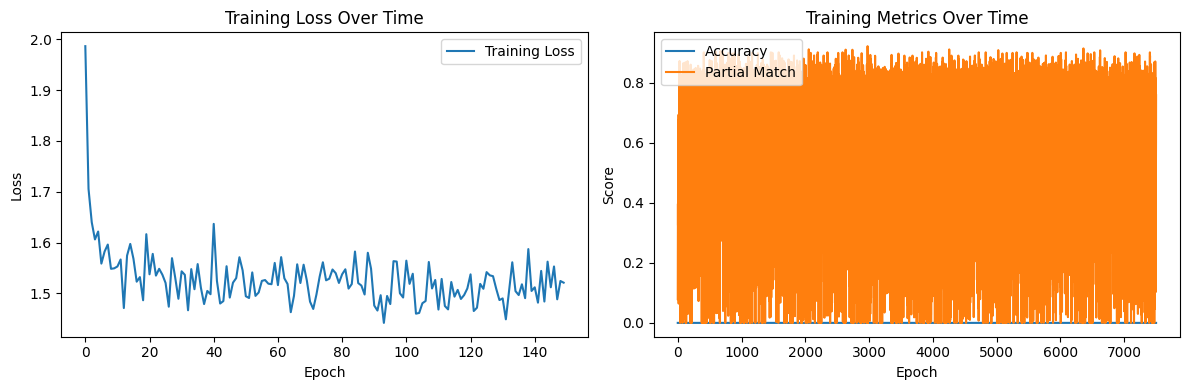

In [63]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(overfit_history["train_loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(overfit_history["accuracy"], label="Accuracy")
plt.plot(overfit_history["partial_match"], label="Partial Match")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Training Metrics Over Time")
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
config = {"epochs": 8, "batch_size": 4, "lr": 5e-5, "gradient_accumulation_steps": 4, "warmup_steps": 200, "weight_decay": 0.01, 'max_grad_norm': 1000.0, 'save_every': 5, 'freeze_after': 5}

In [49]:
history = training(arc_model, models["tokenizer"], dataset, config)

Total steps: 6832


Train Epoch 1: 100%|██████████| 854/854 [53:35<00:00,  3.77s/it]


Epoch 1, Training Loss: 1.688817


Val Epoch 1: 100%|██████████| 32/32 [00:38<00:00,  1.22s/it]
Epoch 1, Train Loss: 1.6888173302107727
Epoch 1, Val Loss: 2.667236328125
Epoch 1, Accuracy: 0.0
Epoch 1, Partial Match: 0.5083654162963459
Train Epoch 2: 100%|██████████| 854/854 [52:53<00:00,  3.72s/it] 


Epoch 2, Training Loss: 0.857070


Val Epoch 2: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
Epoch 2, Train Loss: 0.8570696721311475
Epoch 2, Val Loss: 2.60693359375
Epoch 2, Accuracy: 0.0
Epoch 2, Partial Match: 0.5093903636872779
Train Epoch 3: 100%|██████████| 854/854 [52:01<00:00,  3.65s/it]


Epoch 3, Training Loss: 0.833422


Val Epoch 3: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
Epoch 3, Train Loss: 0.8334217652224825
Epoch 3, Val Loss: 2.606201171875
Epoch 3, Accuracy: 0.0
Epoch 3, Partial Match: 0.5168680869486676
Train Epoch 4: 100%|██████████| 854/854 [52:17<00:00,  3.67s/it]


Epoch 4, Training Loss: 0.856169


Val Epoch 4: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
Epoch 4, Train Loss: 0.8561685816744731
Epoch 4, Val Loss: 2.673828125
Epoch 4, Accuracy: 0.0
Epoch 4, Partial Match: 0.51959592025166
Train Epoch 5: 100%|██████████| 854/854 [52:23<00:00,  3.68s/it]


Epoch 5, Training Loss: 0.800571


Val Epoch 5: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
Epoch 5, Train Loss: 0.8005708430913349
Epoch 5, Val Loss: 2.71044921875
Epoch 5, Accuracy: 0.0
Epoch 5, Partial Match: 0.5221336755163837
Train Epoch 6: 100%|██████████| 854/854 [52:07<00:00,  3.66s/it]


Epoch 6, Training Loss: 0.778839


Val Epoch 6: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
Epoch 6, Train Loss: 0.778839468676815
Epoch 6, Val Loss: 2.4990234375
Epoch 6, Accuracy: 0.0
Epoch 6, Partial Match: 0.5192978780375075
Train Epoch 7: 100%|██████████| 854/854 [52:05<00:00,  3.66s/it]


Epoch 7, Training Loss: 0.808145


Val Epoch 7: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
Epoch 7, Train Loss: 0.8081454918032787
Epoch 7, Val Loss: 2.674560546875
Epoch 7, Accuracy: 0.0
Epoch 7, Partial Match: 0.5205746254827519
Train Epoch 8: 100%|██████████| 854/854 [52:04<00:00,  3.66s/it]


Epoch 8, Training Loss: 0.833403


Val Epoch 8: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]
Epoch 8, Train Loss: 0.8334034689695551
Epoch 8, Val Loss: 2.51904296875
Epoch 8, Accuracy: 0.0
Epoch 8, Partial Match: 0.5223310104170362


In [52]:
@eval
def evaluate(model, tokenizer, dataset, config):
    test_dataloader = torch.utils.data.DataLoader(
        dataset["test"], batch_size=config["batch_size"], collate_fn=collate(mode="test", tokenizer=tokenizer)
    )

    history = {"accuracy": [], "partial_match": []}

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Test Batches", total=len(test_dataloader)):
            outputs = model(**batch)

            B = outputs["outputs"].shape[0]
            pred = outputs["outputs"].reshape(B, 30, 30, 10).argmax(dim=-1).numpy()  # (B, 30, 30)
            labels = batch["targets"]["padded_matrix"]
            masks = np.array(
                [pad_matrix(np.ones((r, c)), 30, 30) for r, c in zip(batch["targets"]["original_rows"], batch["targets"]["original_cols"])]
            )  # (B, 30, 30), where 1 is the original value and 0 is the padded value

            metrics = compute_metrics(pred, labels, masks)

            history["accuracy"].append(metrics["accuracy"])
            history["partial_match"].append(metrics["partial_match"])

    return history

In [50]:
config = {"batch_size": 2}

In [53]:
eval_history = evaluate(arc_model, models["tokenizer"], dataset, config)
eval_history

Test Batches: 100%|██████████| 147/147 [01:01<00:00,  2.37it/s]


{'accuracy': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
 

In [54]:
np.mean(eval_history["accuracy"]), np.mean(eval_history["partial_match"])

(0.0, 0.46598168437372994)

In [73]:
import datasets
datasets.disable_progress_bars()

In [90]:
def evaluate_active_learning(model, tokenizer, dataset, config):
    """
    Evaluate the model using an active learning approach with random augmentations:
    
    1. For each test example, use leave-one-out on the few shots.
    2. Generate random augmentations (between 3 and 7) for each few shot.
    3. Train the model for one iteration on the augmented data using AMP autocasting and gradient clipping.
    4. Generate a prediction on the test challenge and compute evaluation metrics.
    
    After training, the original model weights are restored.
    """
    # Set seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    
    augmentation_functions = [
        lambda x: rotate_grid(x, k=1),
        lambda x: rotate_grid(x, k=2),
        lambda x: rotate_grid(x, k=3),
        lambda x: flip_grid(x, axis=0),
        lambda x: flip_grid(x, axis=1),
        lambda x: expand_grid(x, factor=2),
        lambda x: expand_grid(x, factor=3),
        lambda x: roll_grid(x, shift=1, axis=0),
        lambda x: roll_grid(x, shift=1, axis=1),
        lambda x: roll_grid(x, shift=2, axis=0),
        lambda x: mirror_grid(x),
        lambda x: tile_grid(x, tiles=(2, 2)),
        lambda x: swap_quadrants(x, order=[1, 2, 3, 0]),
    ]
    
    history = {"accuracy": [], "partial_match": []}
    
    # Iterate over each test example
    for test_instance in tqdm(dataset["test"], desc="Test Examples"):
        few_shots = test_instance["challenge"]["train"]
        augmented_data = []
        
        # Create augmented challenges using leave-one-out on the few shots
        while len(augmented_data) < 50: # TODO: testing if 50 is enough
            for i, shot in enumerate(few_shots):
                challenge = {
                    "train": few_shots[:i] + few_shots[i+1:],
                    "test": {"input": shot["input"]},
                }
                
                # Randomly sample a number of augmentations (between 3 and 7)
                n_augmentations = np.random.randint(3, 8)
                selected_augs = np.random.choice(augmentation_functions, size=n_augmentations, replace=False)
                
                # Generate augmentations for the challenge
                for aug_func in selected_augs:
                    try:
                        aug_challenge = augment_challenge(challenge, aug_func)
                        augmented_data.append({
                            "challenge": aug_challenge,
                            "solution": shot["output"]
                        })
                    except Exception as e:
                        # Skip failed augmentations
                        continue
        
        if len(augmented_data) == 0:
            continue
        
        # Build an augmented training dataset and process it
        train_dataset = Dataset.from_list(augmented_data)
        train_dataset = train_dataset.map(lambda x: process_dataset(x, train_dataset["solution"]), batched=True)
        
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=config["batch_size"],
            collate_fn=collate("train", tokenizer),
            shuffle=True
        )
        
        # Save original model weights
        original_weights = {name: param.clone() for name, param in model.named_parameters()}
        optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])
        model.train()
        
        # One iteration training with AMP autocast and gradient clipping on the augmented data
        for batch in train_dataloader:
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(**batch)
                loss = outputs["loss"]
            
            if torch.isnan(loss):
                print("NaN loss detected during active learning training, skipping batch.")
                continue
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.get("max_grad_norm", 1.0))
            optimizer.step()
            optimizer.zero_grad()
        
        # Prepare test data for the active learning evaluation.
        # Use the original challenge (without augmentation) to generate the input messages.
        test_challenge = {
            "train": test_instance["challenge"]["train"],
            "test": test_instance["challenge"]["test"]
        }
        # Use create_chat to generate the proper messages structure.
        chat = create_chat(test_challenge, solution=test_instance.get("solution"))
        test_item = {"messages": chat}
        test_batch = collate("test", tokenizer)([test_item])
        
        # Inference with no_grad
        model.eval()
        with torch.no_grad():
            outputs = model(**test_batch)
            B = outputs["outputs"].shape[0]
            pred = outputs["outputs"].reshape(B, 30, 30, 10).argmax(dim=-1).numpy()
            labels = np.array([pad_matrix(r, 30, 30) for r in [test_instance["solution"]]])
            masks = np.array([
                pad_matrix(np.ones((len(test_instance["solution"]), len(test_instance["solution"][0]))), 30, 30)
            ])
            metrics = compute_metrics(pred, labels, masks)
            history["accuracy"].append(metrics["accuracy"])
            history["partial_match"].append(metrics["partial_match"])
        
        # Restore original model weights
        for name, param in model.named_parameters():
            param.data = original_weights[name]
    
    return history

In [91]:
config = {"batch_size": 2, "lr": 5e-5, "max_grad_norm": 1000.0}

In [92]:
active_learning_history = evaluate_active_learning(arc_model, models["tokenizer"], dataset, config)

Test Examples: 100%|██████████| 293/293 [2:53:15<00:00, 35.48s/it]


In [80]:
print(np.mean(active_learning_history["accuracy"]), np.mean(active_learning_history["partial_match"]))

0.013651877133105802 0.49204021330218634


In [93]:
print(np.mean(active_learning_history["accuracy"]), np.mean(active_learning_history["partial_match"]))

0.006825938566552901 0.4979172876713291
